In [1]:
import UWGeodynamics as GEO
import numpy as np
from underworld import function as fn
from UWGeodynamics import visualisation as glucifer
from MechanicalProperties import PlateProperties
from ModelGeometry import SubductionCreator,interpolateTracer,rmRepeated,fuseListM,ListToNd

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
#Units
u = GEO.UnitRegistry
#Rebecca et al., Scaling
dRho =   80. * u.kilogram / u.meter**3 # matprop.ref_density
g    =   9.8 * u.meter / u.second**2   # modprop.gravity
H    = 800. * u.kilometer #  modprop.boxHeight-- OR 840 dependig if I include the sticky air layer

# lithostatic pressure for mass-time-length
ref_stress = dRho * g * H
# viscosity of upper mante for mass-time-length
ref_viscosity = 1e20 * u.pascal * u.seconds
#References
ref_time        = ref_viscosity/ref_stress
ref_length      = H
ref_mass        = (ref_viscosity*ref_length*ref_time)
#ref_temperature = modprop.Tint - modprop.Tsurf

KL = ref_length       
KM = ref_mass         
Kt = ref_time
#KT = ref_temperature

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
#GEO.scaling_coefficients["[temperature]"] = KT

In [3]:
#Model Dimensions
Model = GEO.Model(elementRes=(296,160), #296,160 #296,128, #120,64
                  minCoord=(-3800. * u.kilometer, -800.0 * u.kilometer), 
                  maxCoord=(3800. * u.kilometer, 0.0 * u.kilometer),
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

#Model Output Folder
Model.outputDir = "outputs_MechanicalTransference_BenchmarkFinal_35kmArc_80Ma_DruckerPrager_WLM_Long"


In [4]:
#need to find an expression to calculate the length of decoupling layer in function of resolution....the minimum working
#value to quickly achieve subduction without overlubricate the subduction zone

In [5]:
#Model Geometry 
#Decoupling Layer- 70 Km for 296, for 120, 110
DipAngle=30
DipLen=300
#SubductionCreator(Model,y0,thickness, dipAngle, dipLength, maxLength, orientation, SLayers,OLayers, ExLens,bStrips,tD=False)
geometry=SubductionCreator(Model,0,100,DipAngle,DipLen,3400,-1,4,2,(210,210,210,210),(40,40,40,40),(True,True, True, True),0.)
xcoords = GEO.uw.function.input()[0]
ycoords = GEO.uw.function.input()[1]
#Model limits
orientation=geometry[6][0]
xlimit=GEO.nd(geometry[6][1])
#cratLim=GEO.nd(geometry[8][2])

In [6]:
#PlateProperties(Nlayers,crustThickness,crustDensity,mantleDensity,plateThickness,oceanic,age, cohesion,friction,arc,arcDensity,arcThickness,depthToMantle)
#Oceanic Plate
data1=PlateProperties(4,7.,2900.,3400.,100.,True,80.,12.5,12.5,0.066,0.033,False,0.,0.,100.,2.)
#Cratonic continental - Values can be +5MPa!!
data2=PlateProperties(2,40.,2700.,3400.,150.,False,80.,15.,10.,0.15,0.08,False,0.,0.,150.,.2)
#Back-arc
data3=PlateProperties(2,20.,2800.,3400.,100.,False,80.,10.,7.5,0.005,0.0035,False,0.,0.,80.,2.) #the last specifies how much was extended the lithosphere
#Arc Crust
data4=PlateProperties(4,7.,2900.,3400.,100.,True,80.,12.5,12.5,0.066,0.033,True,2838.,35.,100.,2.)
#eclogite-Properties
data5=PlateProperties(4,7.,3500.,3400.,100.,True,80.,12.5,12.5,0.066,0.033,False,0.,0.,100.,2.)

/usr/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


In [7]:
#lower Mantle density estimation- According to literature:
(1.6+7)/2
3400+3400*(0.043)

3546.2

In [8]:
(1.6+7)/2

4.3

In [9]:
#Densities without units 
refD=3400.0 * u.kilogram / u.metre**3 #Mantle Density
#(Subducting plate)
l1d=data1[2][0]* u.kilogram / u.metre**3 
l2d=data1[2][1]* u.kilogram / u.metre**3 
l3d=data1[2][2]* u.kilogram / u.metre**3 
l4d=data1[2][3]* u.kilogram / u.metre**3 
#Cratonic overriding plate
cl1=data2[2][0]* u.kilogram / u.metre**3 
cl2=data2[2][1]* u.kilogram / u.metre**3 
#Back-Arc overriding plate
bl1=data3[2][0]* u.kilogram / u.metre**3 
bl2=data3[2][1]* u.kilogram / u.metre**3 
#Arc density
al1=data4[2][0]* u.kilogram / u.metre**3 
al2=data4[2][1]* u.kilogram / u.metre**3 
#Oceanic crust to Eclogite
e1d=data5[2][0]* u.kilogram / u.metre**3
#Lower Mantle density - 1.6 +-1 to 5+-2 percentage the upper mantle density - (1.6+7)/2/100 - 3400.+(3400*0.043)
LMdensity=3546.2* u.kilogram / u.metre**3

In [10]:
## Calculate Geometry
#SubductionCreator(Model,y0,thickness, dipAngle, dipLength, maxLength, orientation, SLayers,OLayers, ExLens,bStrips,tD=False)
#return subducting,overriding, weak,arc,bstop
#Materials in the model
#stickyAir=Model.add_material(name="StickyAir", shape=GEO.shapes.Layer(top=40.*u.kilometer, bottom=0.*u.kilometer))
UMantle =Model.add_material(name="UpperMantle", shape=GEO.shapes.Layer(top=0.*u.kilometer, bottom=-660.*u.kilometer))
#stickyAir = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0. * u.kilometer))
LMantle=Model.add_material(name="LowerMantle", shape=GEO.shapes.Layer(top=-660.*u.kilometer, bottom=Model.bottom))
#OLithosphere1D = Model.add_material(name="SubductingPlateL1", shape=geometry[0][0][0])
#OLithosphere2D=Model.add_material(name="SubductingPlateL2", shape=geometry[0][0][1])
#OLithosphere3D=Model.add_material(name="SubductingPlateL3", shape=geometry[0][0][2])
#OLithosphere4D=Model.add_material(name="SubductingPlateL4", shape=geometry[0][0][3])
OLithosphere1F = Model.add_material(name="SubductingPlateL1", shape=geometry[0][2][0])
OLithosphere2F=Model.add_material(name="SubductingPlateL2", shape=geometry[0][2][1])
OLithosphere3F=Model.add_material(name="SubductingPlateL3", shape=geometry[0][2][2])
OLithosphere4F=Model.add_material(name="SubductingPlateL4", shape=geometry[0][2][3])
Clithosphere1= Model.add_material(name="Overriding plate Crust", shape=geometry[1][0])
Clithosphere2= Model.add_material(name="Overriding plate Lithosphere", shape=geometry[1][1])
Clithosphereweak1=Model.add_material(name="Overriding plate Weak Crust", shape=geometry[2][0])
Clithosphereweak2=Model.add_material(name="Overriding plate Weak Lithosphere", shape=geometry[2][1])
# decoup1= Model.add_material(name="Decoupling", shape=geometry[4][0])
# decoup2= Model.add_material(name="Decoupling", shape=geometry[4][1])
# decoup3= Model.add_material(name="Decoupling", shape=geometry[4][2])
# decoup4= Model.add_material(name="Decoupling", shape=geometry[4][3])
#backstop1=Model.add_material(name="Back Stop", shape=geometry[4][0])
#backstop2=Model.add_material(name="Back Stop", shape=geometry[4][1])
#backstop3=Model.add_material(name="Back Stop", shape=geometry[4][2])
#backstop4=Model.add_material(name="Back Stop", shape=geometry[4][3])
OArc1=Model.add_material(name="IntraOceanicArc", shape=geometry[3][0])
OArc2=Model.add_material(name="IntraOceanicArc", shape=geometry[3][1])
# sg11=Model.add_material(name="Weakness1", shape=geometry[5][0])
# sg12=Model.add_material(name="Weakness2", shape=geometry[5][1])
# sg13=Model.add_material(name="Weakness3", shape=geometry[5][2])
# sg14=Model.add_material(name="Weakness4", shape=geometry[5][3])

In [11]:
# #Eclogite material
# eclogite=Model.add_material(name="EclogiteTrans")
# #Orogenic wedge material
# #Owedge=Model.add_material(name="Orogen Material"))


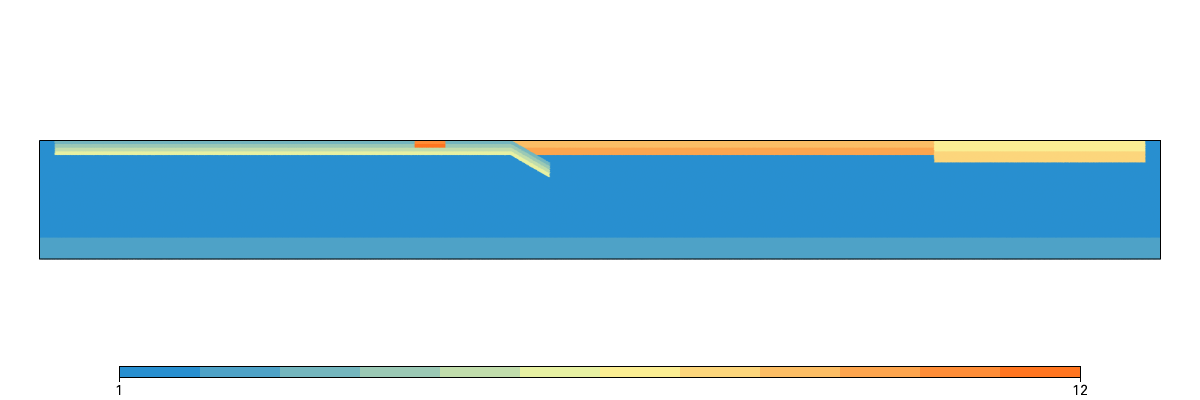

In [12]:
#Preview of 2D materials-Materials Field (from swarm)
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField,fn_size=2.0, discrete=True)
#Fig.Surface(Model.mesh,Model.projMaterialField,fn_size=2.0)
Fig.show()

In [13]:
#Lateral Change in density or not in this model.
LateralChange=False
if LateralChange==True:
    fac=1.
else:
    fac=0.

#Parameters
if orientation==1:
    SPdelta = (GEO.nd(Model.maxCoord[0])-(GEO.nd(xlimit)) - (GEO.nd(100 * u.kilometer)))
elif orientation==-1:
    SPdelta = (GEO.nd(Model.minCoord[0])-(GEO.nd(xlimit)) + (GEO.nd(100 * u.kilometer)))
#Conditions for both orientations

if orientation==1:
    c5="xcoords < xlimit"
elif orientation==-1:
    c5="xcoords > xlimit"
#If orientation =1
conditionsL=[(geometry[0][1][0],(fac*(GEO.nd((refD-l1d))/SPdelta)*(fn.math.abs(GEO.nd(xcoords-(xlimit)))))+GEO.nd(l1d)),
            (geometry[0][1][1],(fac*(GEO.nd((refD-l2d))/SPdelta)*(fn.math.abs(GEO.nd(xcoords-(xlimit)))))+GEO.nd(l2d)),
            (geometry[0][1][2],(fac*(GEO.nd((refD-l3d))/SPdelta)*(fn.math.abs(GEO.nd(xcoords-(xlimit)))))+GEO.nd(l3d)),
            (geometry[0][1][3],(fac*(GEO.nd((refD-l4d))/SPdelta)*(fn.math.abs(GEO.nd(xcoords-(xlimit)))))+GEO.nd(l4d)),
            (geometry[0][0][0],GEO.nd(l1d)),
            (geometry[0][0][1],(GEO.nd((l2d)))),
            (geometry[0][0][2],(GEO.nd((l3d)))),
            (geometry[0][0][3],(GEO.nd((l4d)))),
             (Model.y > GEO.nd(-660.*u.kilometer),GEO.nd(refD)),
            (True,GEO.nd(LMdensity))]

#If orientation =-1

conditionsR=[(geometry[0][1][0],(fac*(GEO.nd((refD-l1d))/SPdelta)*((GEO.nd(xcoords-(xlimit)))))+GEO.nd(l1d)),
            (geometry[0][1][1],(fac*(GEO.nd((refD-l2d))/SPdelta)*((GEO.nd(xcoords-(xlimit)))))+GEO.nd(l2d)),
            (geometry[0][1][2],(fac*(GEO.nd((refD-l3d))/SPdelta)*((GEO.nd(xcoords-(xlimit)))))+GEO.nd(l3d)),
            (geometry[0][1][3],(fac*(GEO.nd((refD-l4d))/SPdelta)*((GEO.nd(xcoords-(xlimit)))))+GEO.nd(l4d)),
            (geometry[0][0][0],GEO.nd(l1d)),
            (geometry[0][0][1],(GEO.nd((l2d)))),
            (geometry[0][0][2],(GEO.nd((l3d)))),
            (geometry[0][0][3],(GEO.nd((l4d)))),
            (Model.y > GEO.nd(-660.*u.kilometer),GEO.nd(refD)),
            (True,GEO.nd(LMdensity))]

if orientation==1:
    conditionsD=conditionsL
elif orientation==-1:
    conditionsD=conditionsR


RoFn =  fn.branching.conditional(conditionsD)
RoField=GEO.uw.swarm.SwarmVariable(Model.swarm,dataType="double",count=1)
RoField.data[:]=RoFn.evaluate(Model.swarm)


In [14]:
#Eclogitization parametrization
conditions=[(Model.y > GEO.nd(-150.*u.kilometer),RoField),
            (True,GEO.nd(e1d)),
    
]
eclogiteFn=fn.branching.conditional(conditions)

In [15]:
## Density- Includes relative density calculation for arc
#stickyAir.density = 100. * u.kilogram / u.metre**3
UMantle.density = RoField
LMantle.density = RoField 
OLithosphere1F.density =eclogiteFn
OLithosphere2F.density =RoField
OLithosphere3F.density =RoField
OLithosphere4F.density =RoField
Clithosphere1.density=cl1  
Clithosphere2.density=cl2
Clithosphereweak1.density=bl1 
Clithosphereweak2.density=bl2
# decoup1.density=bl1 
# decoup2.density=bl1 
# decoup3.density=bl2
# decoup4.density=bl2 
OArc1.density=al1 
OArc2.density=al2 
# sg11.density=RoField
# sg12.density=RoField
# sg13.density=RoField
# sg14.density=RoField
# eclogite.density=e1d

/opt/venv/lib/python3.7/site-packages/UWGeodynamics/__init__.py:91: UserWarning: 'Dimensionalize' has been changed to 'dimensionalise', please use the later
  warnings.warn("""'Dimensionalize' has been changed to 'dimensionalise', please use the later""")



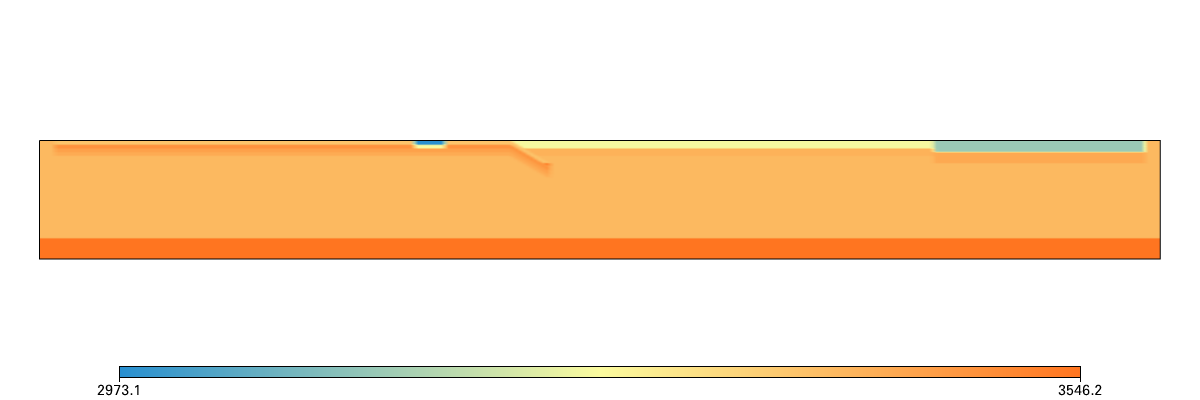

In [16]:
#Density Field
Fig = glucifer.Figure(figsize=(1200,400))
#Fig.Points(Model.swarm, GEO.Dimensionalize(Model.densityField, u.kilogram / u.metre**3))
Fig.Surface(Model.mesh, GEO.Dimensionalize(Model.projDensityField, u.kilogram / u.metre**3))
Fig.show()

In [17]:
#Viscosities without units 
refV=1e20 #UMantle as reference Viscosity
#(Subducting plate)
vl1d=data1[3][0]
vl2d=data1[3][1]
vl3d=data1[3][2]
vl4d=data1[3][3]
#Cratonic overriding plate
vcl1=data2[3][0]
vcl2=data2[3][1]
#Back-Arc overriding plate
vbl1=data3[3][0]
vbl2=data3[3][1]
#Arc viscosity -- Consider what discussed in Len & Gurnis, 2015 (lower-middle crust is very weak)
val1=data4[3][0]
val2=data4[3][1]
# #Eclogite viscosity
# ve1=data5[3][0]

In [18]:
#Update Viscosity for material transition
#a=fn.Function()

In [19]:
#stickyAir.viscosity=1e19 * u.pascal * u.second
Model.minViscosity=refV * u.pascal * u.second
UMantle.viscosity =  refV * u.pascal * u.second#UMantle as reference Viscosity
LMantle.viscosity =  30*refV* u.pascal * u.second
#OLithosphere1D.viscosity = 1e5*refV * u.pascal * u.second
#OLithosphere2D.viscosity = 1e5*refV* u.pascal * u.second
#OLithosphere3D.viscosity = 1.93*10**(4)*refV* u.pascal * u.second
#OLithosphere4D.viscosity = 9.64*10**(1)*refV* u.pascal * u.second
OLithosphere1F.viscosity = vl1d* u.pascal * u.second
OLithosphere2F.viscosity = vl2d* u.pascal * u.second
OLithosphere3F.viscosity = vl3d* u.pascal * u.second
OLithosphere4F.viscosity = vl4d* u.pascal * u.second
Clithosphere1.viscosity= vcl1 * u.pascal * u.second
Clithosphere2.viscosity= vcl2 *u.pascal * u.second
Clithosphereweak1.viscosity= vbl1 * u.pascal * u.second
Clithosphereweak2.viscosity= vbl2* u.pascal * u.second#
# decoup1.viscosity= 10**(0)*vbl1 * u.pascal * u.second
# decoup2.viscosity= 10**(0)*vbl1* u.pascal * u.second #
# decoup3.viscosity= 10**(0)*vbl2* u.pascal * u.second #
# decoup4.viscosity= 10**(0)*vbl2* u.pascal * u.second 
#backstop1.viscosity=1e25* u.pascal * u.second
#backstop2.viscosity=1e25* u.pascal * u.second
#backstop3.viscosity=1e25* u.pascal * u.second
#backstop4.viscosity=1e25* u.pascal * u.second
# sg11.viscosity= 10**(-2)*vl1d* u.pascal * u.second
# sg12.viscosity= 10**(-2)*vl2d* u.pascal * u.second
# sg13.viscosity=10**(-2)*vl3d* u.pascal * u.second
# sg14.viscosity=10**(-1)*vl4d* u.pascal * u.second
OArc1.viscosity= val1 * u.pascal * u.second
OArc2.viscosity= val2* u.pascal * u.second 
# eclogite.viscosity=refV *(10**(2))* u.pascal * u.second


In [39]:
OLithosphere1F.viscosity.viscosity

1.0000000000000001e+25 <Unit('pascal * second')>

In [40]:
OLithosphere2F.viscosity.viscosity

1.0000000000000001e+25 <Unit('pascal * second')>

In [41]:
OLithosphere3F.viscosity.viscosity

1.9296439199637784e+24 <Unit('pascal * second')>

In [42]:
OLithosphere4F.viscosity.viscosity

9.6408351149480036e+21 <Unit('pascal * second')>

In [44]:
Clithosphereweak2.viscosity.viscosity

1.7186790723386029e+22 <Unit('pascal * second')>

In [47]:
Clithosphere2.viscosity.viscosity


1.4763246497864865e+24 <Unit('pascal * second')>

In [20]:
#MinViscosity for materials
OLithosphere1F.minViscosity =10**(21) * u.pascal * u.second
OLithosphere2F.minViscosity = 10**(21) * u.pascal * u.second
OLithosphere3F.minViscosity = 10**(21) * u.pascal * u.second
OLithosphere4F.minViscosity = 10**(21) * u.pascal * u.second
Clithosphereweak1.minViscosity= 10**(21) * u.pascal * u.second
Clithosphereweak2.minViscosity=10**(21) * u.pascal * u.second


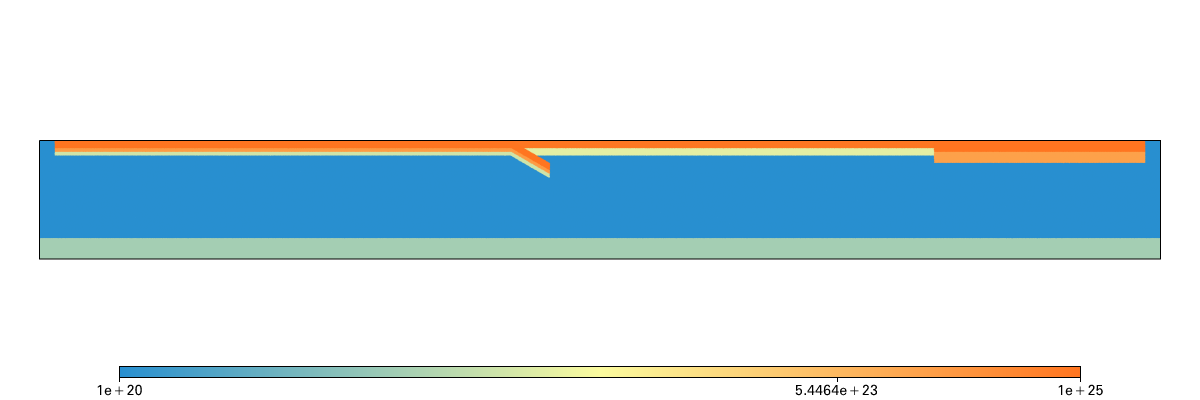

In [21]:
#Viscosity Field
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, GEO.Dimensionalize(Model.viscosityField, u.pascal * u.second),logScale=True)
Fig.show()

In [22]:
#Plasticity- Mechanical Strength
weakSP=True #4,5,6,7 -(4,5) (6,7)
weakOP=True
#(Subducting plate)
if weakSP==True:
    pl1d=(data1[6][0],data1[7][0])
    pl2d=(data1[6][1],data1[7][1])
    pl3d=(data1[6][2],data1[7][2])
    pl4d=(data1[6][3],data1[7][3])
else:
    pl1d=(data1[4][0],data1[7][0])
    pl2d=(data1[4][1],data1[7][1])
    pl3d=(data1[4][2],data1[7][2])
    pl4d=(data1[4][3],data1[7][3])
#Cratonic overriding plate
if weakOP==True:
    pcl1=(data2[4][0],data2[5][0])
    pcl2=(data2[4][1],data2[5][1])
else:
    pcl1=(data2[4][0],data2[5][0])
    pcl2=(data2[4][1],data2[5][1])
#Back-Arc overriding plate
if weakOP==True:
    pbl1=(data3[4][0],data3[5][0])
    pbl2=(data3[4][1],data3[5][1])
else:
    pbl1=(data3[6][0],data3[7][0])
    pbl2=(data3[6][1],data3[7][1])
#Arc Plasticity -- Consider what discussed in Len & Gurnis, 2015 (lower-middle crust is very weak)
if weakSP==True:
    pal1=(data4[6][0],data4[7][0])
    pal2=(data4[6][1],data4[7][1])
else:
    pal1=(data4[4][0],data4[5][0])
    pal2=(data4[4][1],data4[5][1])

In [23]:
# Drucker-Prager-
OLithosphere1F.plasticity = GEO.DruckerPrager(cohesion=12.5 * u.megapascal,
                                            frictionCoefficient=0.008,
                                              #cohesionAfterSoftening=12.5/2. * u.megapascal,
                                              frictionAfterSoftening=0.00001, #Serpentinization (shallow 25 Km)
                                             epsilon1=0.0, 
                                             epsilon2=0.2)
OLithosphere2F.plasticity = GEO.DruckerPrager(cohesion=12.5 * u.megapascal,
                                              frictionCoefficient=0.008,
                                              cohesionAfterSoftening=12.5/2. * u.megapascal,
                                              frictionAfterSoftening=0.0045, #to 0.0035 ? from 0.0027
                                             epsilon1=0.0,
                                             epsilon2=0.2)
OLithosphere3F.plasticity =GEO.DruckerPrager(cohesion=12.5 * u.megapascal,
                                             frictionCoefficient= 0.01,
                                             cohesionAfterSoftening=12.5/2. * u.megapascal,
                                             frictionAfterSoftening=0.0065,
                                            epsilon1=0.0,
                                            epsilon2=0.2)
# OLithosphere4F.plasticity =GEO.VonMises(cohesion=pl4d[0] * u.megapascal,
#                                              cohesionAfterSoftening=pl4d[1] * u.megapascal,
#                                             epsilon1=0.0,
#                                             epsilon2=0.2)
Clithosphere1.plasticity =GEO.DruckerPrager(cohesion=15. * u.megapascal,  #Mean from Lower and Upper from Rey et al., 2014
                                            frictionCoefficient=0.08,
                                       cohesionAfterSoftening=15./2. * u.megapascal, 
                                       frictionAfterSoftening=0.05,
                                            epsilon1=0.0, epsilon2=0.2)
Clithosphere2.plasticity = GEO.DruckerPrager(cohesion=10. * u.megapascal, 
                                             frictionCoefficient=0.08, #Mean from Lower and Upper from Rey et al., 2014
                                       cohesionAfterSoftening=5. * u.megapascal, 
                                       frictionAfterSoftening=0.05, 
                                             epsilon1=0.0, epsilon2=0.2)
Clithosphereweak1.plasticity = GEO.DruckerPrager(cohesion=15. * u.megapascal,
                                                 frictionCoefficient=0.0055,#Mean from Lower and Upper from Rey et al., 2014
                                       cohesionAfterSoftening=4. * u.megapascal,
                                                 frictionAfterSoftening=0.00001,
                                                 epsilon1=0.0, epsilon2=0.2)
Clithosphereweak2.plasticity = GEO.DruckerPrager(cohesion=10. * u.megapascal, 
                                                 frictionCoefficient=0.0045,#Mean from Lower and Upper from Rey et al., 2014
                                       cohesionAfterSoftening=3.5 * u.megapascal, 
                                                 frictionAfterSoftening=0.0015,
                                                epsilon1=0.0, epsilon2=0.2)   #Friction to zero due to weakening (Patrice personal and Len & Gurnis, 2015)    
OArc1.plasticity = GEO.DruckerPrager(cohesion=12.5 * u.megapascal,
                                            frictionCoefficient=0.008,
                                              #cohesionAfterSoftening=12.5/2. * u.megapascal,
                                              frictionAfterSoftening=0.00001, #Serpentinization (shallow 25 Km)
                                             epsilon1=0.0,
                                             epsilon2=0.20)
OArc2.plasticity = GEO.DruckerPrager(cohesion=12.5 * u.megapascal,
                                            frictionCoefficient=0.008,
                                              cohesionAfterSoftening=12.5/6. * u.megapascal,
                                              frictionAfterSoftening=0.00001, #Serpentinization (shallow 25 Km)
                                             epsilon1=0.0,
                                             epsilon2=0.20)
# decoup1.plasticity=GEO.DruckerPrager(cohesion=10/4. * u.megapascal,
#                                                  frictionCoefficient=0.0,#Mean from Lower and Upper from Rey et al., 2014
#                                        cohesionAfterSoftening=0.6 * u.megapascal,
#                                                  #frictionAfterSoftening=0.001,
#                                                  epsilon1=0.0, epsilon2=0.01)
# decoup2.plasticity=GEO.DruckerPrager(cohesion=10/4. * u.megapascal,
#                                                  frictionCoefficient=0.0,#Mean from Lower and Upper from Rey et al., 2014
#                                        cohesionAfterSoftening=0.6 * u.megapascal,
#                                                  #frictionAfterSoftening=0.001,
#                                                  epsilon1=0.0, epsilon2=0.01)
# decoup3.plasticity= GEO.DruckerPrager(cohesion=7.5/4. * u.megapascal, 
#                                                  frictionCoefficient=0.0,#Mean from Lower and Upper from Rey et al., 2014
#                                        cohesionAfterSoftening=0.6 * u.megapascal, 
#                                                  #frictionAfterSoftening=0.002,
#                                                 epsilon1=0.0, epsilon2=0.01)   
# decoup4.plasticity= GEO.DruckerPrager(cohesion=7.5/4. * u.megapascal, 
#                                                  frictionCoefficient=0.0,#Mean from Lower and Upper from Rey et al., 2014
#                                        cohesionAfterSoftening=0.6 * u.megapascal, 
#                                                  #frictionAfterSoftening=0.002,
#                                                 epsilon1=0.0, epsilon2=0.01)  
# sg11.plasticity = GEO.VonMises(cohesion=pal1[0]/4. * u.megapascal,
#                                               cohesionAfterSoftening=pal1[1] * u.megapascal,
#                                              epsilon1=0.0,
#                                              epsilon2=0.2)
# sg12.plasticity = GEO.VonMises(cohesion=pal2[0]/4. * u.megapascal,
#                                               cohesionAfterSoftening=pal2[1] * u.megapascal,
#                                              epsilon1=0.0,
#                                              epsilon2=0.2)
# sg13.plasticity =GEO.VonMises(cohesion=pl3d[0]/4. * u.megapascal,
#                                              cohesionAfterSoftening=pl3d[1] * u.megapascal,
#                                             epsilon1=0.0,
#                                             epsilon2=0.2)
# sg14.plasticity =GEO.VonMises(cohesion=pl4d[0]/4. * u.megapascal,
#                                              cohesionAfterSoftening=pl4d[1] * u.megapascal,
#                                             epsilon1=0.0,
#                                             epsilon2=0.2)


In [24]:
# #Passive Tracers- To track plate convergence/retreat rates
SPTracersC=rmRepeated(geometry[7])
OPTracersC=rmRepeated(geometry[8])
ArcTracersC=rmRepeated(geometry[9])
CratonTracersC=rmRepeated(geometry[10])
#Map for vertexes
SPMap=[(0,1),(1,2),(5,4),(4,3),(8,7),(7,6),(11,10),(10,9),(14,13),(13,12)]
# FlatMap=[(0,1),(5,4),(8,7),(11,10),(14,13)]
# DipMap=[(1,2),(4,3),(7,6),(10,9),(13,12)]
OPMap=[(0,1),(2,3),(4,5)]
ArcMap=[(0,1),(2,3),(4,5)]
CratMap=[(0,1),(2,3),(4,5)]

SP=[]
wise=0
for i in SPMap:
    if wise==0:
        npoints=500
        wise=1
    else:
        npoints=100
    aux=i
    SP.append(interpolateTracer([SPTracersC[0][aux[0]],SPTracersC[1][aux[0]]],
                         
                         [SPTracersC[0][aux[1]],SPTracersC[1][aux[1]]],400)) 
OP=[]
aux=OPMap[0]
OP.append(interpolateTracer([OPTracersC[0][aux[0]],OPTracersC[1][aux[0]]],
                         
                         [OPTracersC[0][aux[1]],OPTracersC[1][aux[1]]],400))
aux=OPMap[1]
OP.append(interpolateTracer([OPTracersC[0][aux[0]],OPTracersC[1][aux[0]]],
                         
                         [OPTracersC[0][aux[1]],OPTracersC[1][aux[1]]],400))
aux=OPMap[2]
OP.append(interpolateTracer([OPTracersC[0][aux[0]],OPTracersC[1][aux[0]]],
                         
                         [OPTracersC[0][aux[1]],OPTracersC[1][aux[1]]],400))
OP_Crat=[]
aux=CratMap[0]
OP_Crat.append(interpolateTracer([CratonTracersC[0][aux[0]],CratonTracersC[1][aux[0]]],
                         
                         [CratonTracersC[0][aux[1]],CratonTracersC[1][aux[1]]],400))
aux=CratMap[1]
OP_Crat.append(interpolateTracer([CratonTracersC[0][aux[0]],CratonTracersC[1][aux[0]]],
                         
                         [CratonTracersC[0][aux[1]],CratonTracersC[1][aux[1]]],400))
aux=CratMap[2]
OP_Crat.append(interpolateTracer([CratonTracersC[0][aux[0]],CratonTracersC[1][aux[0]]],
                         
                         [CratonTracersC[0][aux[1]],CratonTracersC[1][aux[1]]],400))

ArcT=[]
aux=ArcMap[0]
ArcT.append(interpolateTracer([ArcTracersC[0][aux[0]],ArcTracersC[1][aux[0]]],
                         
                         [ArcTracersC[0][aux[1]],ArcTracersC[1][aux[1]]],200))
aux=ArcMap[1]
ArcT.append(interpolateTracer([ArcTracersC[0][aux[0]],ArcTracersC[1][aux[0]]],
                         
                         [ArcTracersC[0][aux[1]],ArcTracersC[1][aux[1]]],200))

aux=ArcMap[2]
ArcT.append(interpolateTracer([ArcTracersC[0][aux[0]],ArcTracersC[1][aux[0]]],
                         
                         [ArcTracersC[0][aux[1]],ArcTracersC[1][aux[1]]],200))
#Fusing Data
# SP_F=fuseListM([SP_F[0],SP_F[1],SP_F[2],SP_F[3],SP_F[4]])
SP=fuseListM([SP[0],SP[1],SP[2],SP[3],SP[4],SP[5],SP[6],SP[7]])
OP=fuseListM([OP[0],OP[1],OP[2]])
ArcT=fuseListM([ArcT[0],ArcT[1],ArcT[2]])
CratonT=fuseListM([OP_Crat[0],OP_Crat[1],OP_Crat[2]])

In [25]:
# SP_FlatTracers = Model.add_passive_tracers(name="SPTracers_flat",vertices=[ListToNd(SP_F[0]),ListToNd(SP_F[1])])
SPTracers = Model.add_passive_tracers(name="SPTracers",vertices=[ListToNd(SP[0]),ListToNd(SP[1])])
OPTracers = Model.add_passive_tracers(name="OPTracers",vertices=[ListToNd(OP[0]),ListToNd(OP[1])])
ArcTracers= Model.add_passive_tracers(name="ArcTracers",vertices=[ListToNd((ArcT[0])),ListToNd((ArcT[1]))])
CratonTracers=Model.add_passive_tracers(name="CratonTracers",vertices=[ListToNd((CratonT[0])),ListToNd((CratonT[1]))])


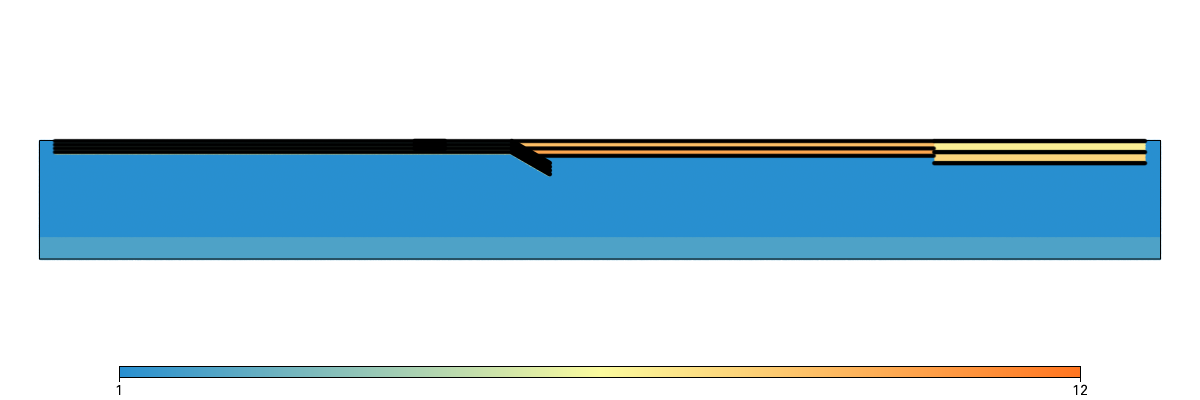

In [26]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(SPTracers, pointSize=5.0)
Fig.Points(OPTracers, pointSize=5.0)
Fig.Points(ArcTracers, pointSize=5.0)
Fig.Points(CratonTracers, pointSize=5.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=3.0)
Fig.show()

In [27]:
#Fields to Record
#Fields to Record

SPTracers.add_tracked_field(Model.velocityField[0],
                              name="Subducting plate velocity_X",
                              units=u.centimeter/ u.year,
                              dataType="float")
SPTracers.add_tracked_field(Model.velocityField[1],
                              name="Subducting plate velocity_Y",
                              units=u.centimeter/ u.year,
                              dataType="float")
ArcTracers.add_tracked_field(Model.velocityField[0],
                              name="Arc nodes velocity_X",
                              units=u.centimeter/ u.year,
                              dataType="float")
ArcTracers.add_tracked_field(Model.velocityField[1],
                              name="Arc nodes velocity_Y",
                              units=u.centimeter/ u.year,
                              dataType="float")
ArcTracers.add_tracked_field(Model.projStressTensor[0],
                              name="Arc stress tensor_X",
                              units=u.megapascal,
                              dataType="float")
ArcTracers.add_tracked_field(Model.projStressTensor[1],
                              name="Arc stress tensor_Y",
                              units=u.megapascal,
                              dataType="float")
ArcTracers.add_tracked_field(Model.projStressTensor[2],
                              name="Arc stress tensor_XY",
                              units=u.megapascal,
                              dataType="float")
ArcTracers.add_tracked_field(Model.strainRateField,
                              name="arc overriding plate strain rate",
                              units=u.megapascal,
                              dataType="float")
ArcTracers.add_tracked_field(Model.projStressField[0],
                              name="arc overriding plate stress Field",
                              units=u.megapascal,
                              dataType="float")
OPTracers.add_tracked_field(Model.velocityField[0],
                              name="Weak overriding plate velocity_X",
                              units=u.centimeter/ u.year,
                              dataType="float")
OPTracers.add_tracked_field(Model.velocityField[1],
                              name="Weak overriding plate velocity_Y",
                              units=u.centimeter/ u.year,
                              dataType="float")
OPTracers.add_tracked_field(Model.strainRateField,
                              name="Weak overriding plate strain rate",
                              units=u.megapascal,
                              dataType="float")
OPTracers.add_tracked_field(Model.projStressField[0],
                              name="Weak overriding plate stress Field",
                              units=u.megapascal,
                              dataType="float")
# OPTracers.add_tracked_field(Model.projStressField[1],
#                               name="Weak overriding plate stress Field_Y",
#                               units=u.megapascal,
#                               dataType="float")
# OPTracers.add_tracked_field(Model.projStressField[3],
#                               name="Weak overriding plate stress Field_XY",
#                               units=u.megapascal,
#                               dataType="float")
OPTracers.add_tracked_field(Model.projStressTensor[0],
                              name="Weak overriding plate stress tensor_X",
                              units=u.megapascal,
                              dataType="float")
OPTracers.add_tracked_field(Model.projStressTensor[1],
                              name="Weak overriding plate stress tensor_Y",
                              units=u.megapascal,
                              dataType="float")
OPTracers.add_tracked_field(Model.projStressTensor[2],
                              name="Weak overriding plate stress tensor_XY",
                              units=u.megapascal,
                              dataType="float")
SPTracers.add_tracked_field(Model.projTimeField,
                              name="Time_SP",
                              units=u.megayear,
                              dataType="float")
OPTracers.add_tracked_field(Model.projTimeField,
                              name="Time_OP",
                              units=u.megayear,
                              dataType="float")
CratonTracers.add_tracked_field(Model.projTimeField,
                              name="Time_SP",
                              units=u.megayear,
                              dataType="float")
CratonTracers.add_tracked_field(Model.velocityField[0],
                              name="Cratonic overriding plate velocity_X",
                              units=u.centimeter/ u.year,
                              dataType="float")
CratonTracers.add_tracked_field(Model.velocityField[1],
                              name="Cratonic overriding plate velocity_Y",
                              units=u.centimeter/ u.year,
                              dataType="float")
CratonTracers.add_tracked_field(Model.projStressTensor[0],
                              name="Craton stress tensor_X",
                              units=u.megapascal,
                              dataType="float")
CratonTracers.add_tracked_field(Model.projStressTensor[1],
                              name="Craton stress tensor_Y",
                              units=u.megapascal,
                              dataType="float")
CratonTracers.add_tracked_field(Model.projStressTensor[2],
                              name="Craton stress tensor_XY",
                              units=u.megapascal,
                              dataType="float")
ArcTracers.add_tracked_field(Model.projTimeField,
                              name="Time_Arc",
                              units=u.megayear,
                              dataType="float")

In [28]:
#Free-slip Boundary Conditions (Kinematic BCs)
Model.set_velocityBCs(left=[0., None],
                     right=[0.,None],
                     bottom=[0., 0.],
                     top=[None, 0.])

In [29]:
#Free-Surface
#Model.freeSurface = True

In [30]:
Model.init_model()

In [31]:
#Solver Parameters
Model.solver.set_inner_method("lu")
Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-4

In [32]:
#Data to Save
outputss=['temperature',
        'pressureField',
         'strainRateField',
         'velocityField',
          'projStressField',
          'projTimeField',
           'projMaterialField',
         'projViscosityField',
         'projStressField',
         'projMeltField',
          'projPlasticStrain',
         'projDensityField',
         'projStressTensor',
         ]
GEO.rcParams['default.outputs']=outputss

In [33]:
#Running Model
#!rm -rf output_FirstSubduction/
#Model.run_for(duration=40*u.megayear,checkpoint_interval=0.1*u.megayear,restartStep=-1,restartDir=Model.outputDir)
Model.run_for(duration=110*u.megayear,checkpoint_interval=0.5*u.megayear,restartStep=198)
#Model.run_for(nstep=10, checkpoint_interval=0.1*u.megayear,restartStep=False)

Running with UWGeodynamics version 2.9.5
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Step:     1 Model Time: 301157.2 year dt: 301157.2 year (2021-02-27 10:44:30)
Step:     2 Model Time: 500000.0 year dt: 198842.8 year (2021-02-27 10:45:33)
Step:     3 Model Time: 754659.8 year dt: 254659.8 year (2021-02-27 10:46:10)
Step:     4 Model Time: 1.0 megayear dt: 245340.2 year (2021-02-27 10:47:13)
Step:     5 Model Time: 1.2 megayear dt: 229146.2 year (2021-02-27 10:48:25)
Step:     6 Model Time: 1.4 megayear dt: 193219.0 year (2021-02-27 10:49:07)
Step:     7 Model Time: 1.5 megayear dt: 77634.8 year (2021-02-27 10:50:25)
Step:     8 Model Time: 1.7 megayear dt: 174613.7 year (2021-02-27 10:50:47)
S

Step:   104 Model Time: 6.6 megayear dt: 28004.1 year (2021-02-27 11:36:27)
Step:   105 Model Time: 6.7 megayear dt: 27588.4 year (2021-02-27 11:36:49)
Step:   106 Model Time: 6.7 megayear dt: 27290.3 year (2021-02-27 11:37:11)
Step:   107 Model Time: 6.7 megayear dt: 26551.5 year (2021-02-27 11:37:33)
Step:   108 Model Time: 6.8 megayear dt: 26367.4 year (2021-02-27 11:37:55)
Step:   109 Model Time: 6.8 megayear dt: 26461.5 year (2021-02-27 11:38:16)
Step:   110 Model Time: 6.8 megayear dt: 26765.0 year (2021-02-27 11:38:38)
Step:   111 Model Time: 6.8 megayear dt: 26791.6 year (2021-02-27 11:39:00)
Step:   112 Model Time: 6.9 megayear dt: 27512.9 year (2021-02-27 11:39:22)
Step:   113 Model Time: 6.9 megayear dt: 27824.9 year (2021-02-27 11:39:44)
Step:   114 Model Time: 6.9 megayear dt: 28788.4 year (2021-02-27 11:40:06)
Step:   115 Model Time: 6.9 megayear dt: 30160.9 year (2021-02-27 11:40:28)
Step:   116 Model Time: 7.0 megayear dt: 31460.2 year (2021-02-27 11:40:50)
Step:   117 

Step:   212 Model Time: 9.4 megayear dt: 29336.2 year (2021-02-27 12:19:49)
Step:   213 Model Time: 9.4 megayear dt: 29766.6 year (2021-02-27 12:20:11)
Step:   214 Model Time: 9.4 megayear dt: 29738.7 year (2021-02-27 12:20:33)
Step:   215 Model Time: 9.5 megayear dt: 30270.8 year (2021-02-27 12:20:55)
Step:   216 Model Time: 9.5 megayear dt: 31052.8 year (2021-02-27 12:21:17)
Step:   217 Model Time: 9.5 megayear dt: 9996.4 year (2021-02-27 12:22:24)
Step:   218 Model Time: 9.5 megayear dt: 32949.9 year (2021-02-27 12:22:47)
Step:   219 Model Time: 9.6 megayear dt: 32749.8 year (2021-02-27 12:23:09)
Step:   220 Model Time: 9.6 megayear dt: 32717.9 year (2021-02-27 12:23:31)
Step:   221 Model Time: 9.6 megayear dt: 33154.2 year (2021-02-27 12:23:53)
Step:   222 Model Time: 9.7 megayear dt: 32520.5 year (2021-02-27 12:24:15)
Step:   223 Model Time: 9.7 megayear dt: 32415.2 year (2021-02-27 12:24:36)
Step:   224 Model Time: 9.7 megayear dt: 31984.3 year (2021-02-27 12:24:59)
Step:   225 M

Step:   319 Model Time: 13.7 megayear dt: 60555.0 year (2021-02-27 13:06:06)
Step:   320 Model Time: 13.7 megayear dt: 61604.2 year (2021-02-27 13:06:28)
Step:   321 Model Time: 13.8 megayear dt: 61808.6 year (2021-02-27 13:06:50)
Step:   322 Model Time: 13.9 megayear dt: 62268.6 year (2021-02-27 13:07:12)
Step:   323 Model Time: 13.9 megayear dt: 61651.6 year (2021-02-27 13:07:35)
Step:   324 Model Time: 14.0 megayear dt: 62313.5 year (2021-02-27 13:07:57)
Step:   325 Model Time: 14.0 megayear dt: 9904.7 year (2021-02-27 13:09:05)
Step:   326 Model Time: 14.1 megayear dt: 64024.9 year (2021-02-27 13:09:27)
Step:   327 Model Time: 14.1 megayear dt: 63693.8 year (2021-02-27 13:09:49)
Step:   328 Model Time: 14.2 megayear dt: 64083.9 year (2021-02-27 13:10:11)
Step:   329 Model Time: 14.3 megayear dt: 63588.7 year (2021-02-27 13:10:34)
Step:   330 Model Time: 14.3 megayear dt: 63384.3 year (2021-02-27 13:10:56)
Step:   331 Model Time: 14.4 megayear dt: 63117.8 year (2021-02-27 13:11:18)


Step:   426 Model Time: 18.6 megayear dt: 35385.1 year (2021-02-27 13:53:18)
Step:   427 Model Time: 18.7 megayear dt: 36913.1 year (2021-02-27 13:53:41)
Step:   428 Model Time: 18.7 megayear dt: 36371.3 year (2021-02-27 13:54:03)
Step:   429 Model Time: 18.8 megayear dt: 36561.4 year (2021-02-27 13:54:25)
Step:   430 Model Time: 18.8 megayear dt: 38499.2 year (2021-02-27 13:54:47)
Step:   431 Model Time: 18.8 megayear dt: 36476.7 year (2021-02-27 13:55:09)
Step:   432 Model Time: 18.9 megayear dt: 36656.1 year (2021-02-27 13:55:32)
Step:   433 Model Time: 18.9 megayear dt: 36810.4 year (2021-02-27 13:55:54)
Step:   434 Model Time: 18.9 megayear dt: 37643.7 year (2021-02-27 13:56:16)
Step:   435 Model Time: 19.0 megayear dt: 38001.1 year (2021-02-27 13:56:38)
Step:   436 Model Time: 19.0 megayear dt: 22464.4 year (2021-02-27 13:57:47)
Step:   437 Model Time: 19.0 megayear dt: 37268.4 year (2021-02-27 13:58:09)
Step:   438 Model Time: 19.1 megayear dt: 37982.8 year (2021-02-27 13:58:32)

Step:   533 Model Time: 24.5 megayear dt: 58766.9 year (2021-02-27 14:42:15)
Step:   534 Model Time: 24.6 megayear dt: 63562.3 year (2021-02-27 14:42:37)
Step:   535 Model Time: 24.6 megayear dt: 62926.7 year (2021-02-27 14:42:59)
Step:   536 Model Time: 24.7 megayear dt: 61173.1 year (2021-02-27 14:43:21)
Step:   537 Model Time: 24.8 megayear dt: 64350.1 year (2021-02-27 14:43:43)
Step:   538 Model Time: 24.8 megayear dt: 66545.8 year (2021-02-27 14:44:05)
Step:   539 Model Time: 24.9 megayear dt: 60569.0 year (2021-02-27 14:44:32)
Step:   540 Model Time: 24.9 megayear dt: 59200.8 year (2021-02-27 14:44:55)
Step:   541 Model Time: 25.0 megayear dt: 56778.9 year (2021-02-27 14:45:19)
Step:   542 Model Time: 25.0 megayear dt: 4893.4 year (2021-02-27 14:46:25)
Step:   543 Model Time: 25.1 megayear dt: 59207.9 year (2021-02-27 14:46:47)
Step:   544 Model Time: 25.1 megayear dt: 55771.8 year (2021-02-27 14:47:09)
Step:   545 Model Time: 25.2 megayear dt: 58283.9 year (2021-02-27 14:47:32)


Step:   639 Model Time: 34.6 megayear dt: 88111.5 year (2021-02-27 15:38:09)
Step:   640 Model Time: 34.7 megayear dt: 97125.1 year (2021-02-27 15:38:32)
Step:   641 Model Time: 34.8 megayear dt: 108971.6 year (2021-02-27 15:38:54)
Step:   642 Model Time: 34.9 megayear dt: 116721.1 year (2021-02-27 15:39:16)
Step:   643 Model Time: 35.0 megayear dt: 89070.7 year (2021-02-27 15:40:25)
Step:   644 Model Time: 35.1 megayear dt: 95439.0 year (2021-02-27 15:40:48)
Step:   645 Model Time: 35.2 megayear dt: 110271.6 year (2021-02-27 15:41:10)
Step:   646 Model Time: 35.3 megayear dt: 75203.9 year (2021-02-27 15:41:49)
Step:   647 Model Time: 35.4 megayear dt: 94193.2 year (2021-02-27 15:42:11)
Step:   648 Model Time: 35.5 megayear dt: 86417.5 year (2021-02-27 15:42:33)
Step:   649 Model Time: 35.5 megayear dt: 38474.8 year (2021-02-27 15:43:40)
Step:   650 Model Time: 35.6 megayear dt: 89387.2 year (2021-02-27 15:44:03)
Step:   651 Model Time: 35.7 megayear dt: 99704.5 year (2021-02-27 15:44:

Step:   748 Model Time: 51.5 megayear dt: 212215.6 year (2021-02-27 16:51:59)
Step:   749 Model Time: 51.8 megayear dt: 259296.2 year (2021-02-27 16:52:21)
Step:   750 Model Time: 52.0 megayear dt: 240703.8 year (2021-02-27 16:53:28)
Step:   751 Model Time: 52.3 megayear dt: 267232.4 year (2021-02-27 16:53:56)
Step:   752 Model Time: 52.5 megayear dt: 230369.8 year (2021-02-27 16:54:18)
Step:   753 Model Time: 52.5 megayear dt: 2397.9 year (2021-02-27 16:55:41)
Step:   754 Model Time: 52.8 megayear dt: 272935.7 year (2021-02-27 16:56:04)
Step:   755 Model Time: 53.0 megayear dt: 217868.2 year (2021-02-27 16:56:25)
Step:   756 Model Time: 53.0 megayear dt: 9196.1 year (2021-02-27 16:57:44)
Step:   757 Model Time: 53.2 megayear dt: 228361.4 year (2021-02-27 16:58:06)
Step:   758 Model Time: 53.5 megayear dt: 268137.8 year (2021-02-27 16:58:33)
Step:   759 Model Time: 53.5 megayear dt: 3500.8 year (2021-02-27 16:59:40)
Step:   760 Model Time: 53.8 megayear dt: 253457.6 year (2021-02-27 17

Step:   854 Model Time: 96.5 megayear dt: 500000.0 year (2021-02-27 18:50:13)
Step:   855 Model Time: 97.0 megayear dt: 500000.0 year (2021-02-27 18:51:21)
Step:   856 Model Time: 97.5 megayear dt: 500000.0 year (2021-02-27 18:52:29)
Step:   857 Model Time: 98.0 megayear dt: 500000.0 year (2021-02-27 18:53:37)
Step:   858 Model Time: 98.5 megayear dt: 500000.0 year (2021-02-27 18:55:15)
Step:   859 Model Time: 99.0 megayear dt: 500000.0 year (2021-02-27 18:56:23)
Step:   860 Model Time: 99.5 megayear dt: 500000.0 year (2021-02-27 18:57:32)
Step:   861 Model Time: 100.0 megayear dt: 500000.0 year (2021-02-27 18:58:43)
Step:   862 Model Time: 100.5 megayear dt: 500000.0 year (2021-02-27 18:59:51)
Step:   863 Model Time: 101.0 megayear dt: 500000.0 year (2021-02-27 19:01:04)
Step:   864 Model Time: 101.5 megayear dt: 500000.0 year (2021-02-27 19:02:11)
Step:   865 Model Time: 102.0 megayear dt: 500000.0 year (2021-02-27 19:03:20)
Step:   866 Model Time: 102.5 megayear dt: 500000.0 year (2

1


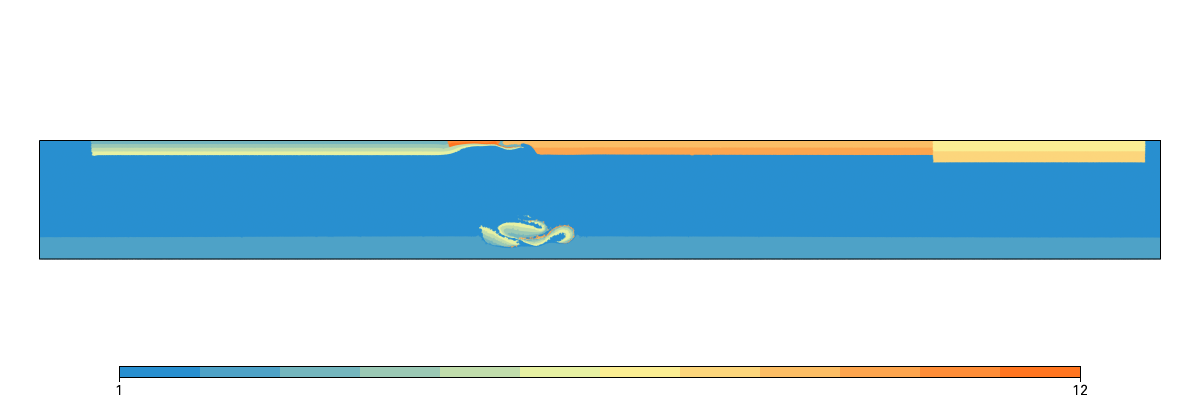

In [34]:
#Preview of 2D materials-Materials Field (from swarm)
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField,fn_size=2.0, discrete=True)
#Fig.Surface(Model.mesh,Model.projMaterialField,fn_size=2.0)
Fig.show()


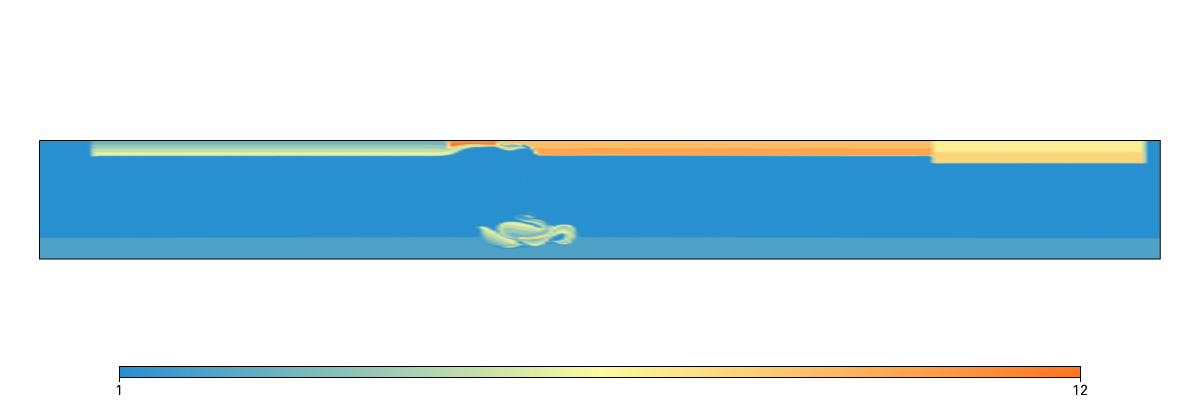

In [35]:
#Preview of 2D materials-Materials Field (from swarm)
Fig = glucifer.Figure(figsize=(1200,400))
#Fig.Points(Model.swarm, Model.materialField,fn_size=2.0, discrete=True)
Fig.Surface(Model.mesh,Model.projMaterialField,fn_size=2.0)
Fig.show()


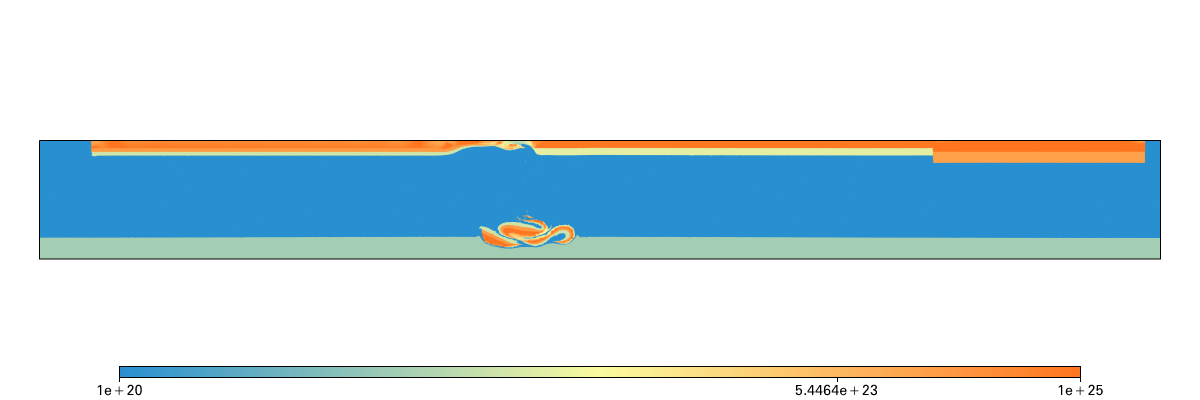

In [36]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, GEO.Dimensionalize(Model.viscosityField, u.pascal * u.second),logScale=True)
Fig.show()


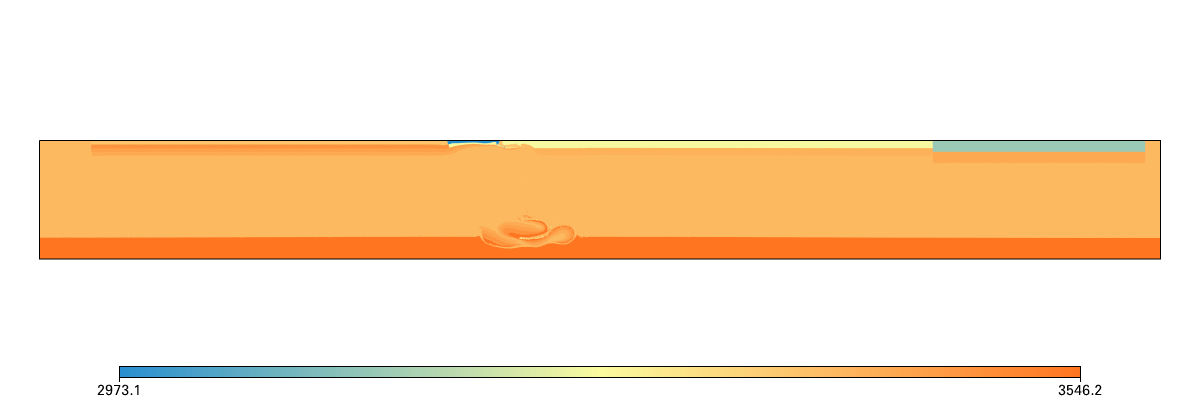

In [37]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, GEO.Dimensionalize(Model.densityField, u.kilogram / u.metre**3))
#Fig.Surface(Model.mesh, GEO.Dimensionalize(Model.projDensityField, u.kilogram / u.metre**3))
Fig.show()